# Normalized Negative Images

Manipulate training data to have the outline pixels highlighted. Apply model on original testing dataset.

In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
import torch.utils.data as data
import torch.utils.data.sampler as sampler
from torch.utils.tensorboard import SummaryWriter
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import network
import mnist_loader

train_loader, validation_loader, test_loader = mnist_loader.load_data(normalize=True, flipped=True)
_, _, test_loader_org = mnist_loader.load_data(flipped=True)

print(len(validation_loader.dataset))

torch.cuda.is_available()

10000


False

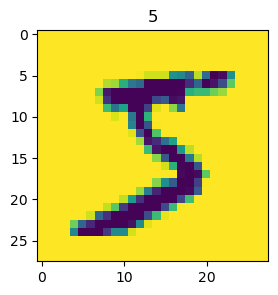

In [2]:
# outlined image

import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))
plt.title(f"{train_loader.dataset[0][1]}")
plt.imshow(train_loader.dataset[0][0][0])
plt.show()

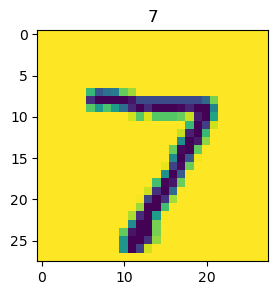

In [3]:
plt.figure(figsize=(3, 3))
plt.title(f"{test_loader_org.dataset[0][1]}")
plt.imshow(test_loader_org.dataset[0][0][0])
plt.show()

In [4]:
# model accuracy check
def accuracy(output, target):
    return sum([torch.argmax(o) == t for o, t in zip(output, target)]), len(target)

## Network 1
Simple network with 3 fully connected layers. Sigmoid activation function. Cross Entropy Loss function.

In [ ]:
eta = 0.3
epochs = 10

net1 = network.Network1()
print(net1)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net1.parameters(), lr=eta)
net1.zero_grad()

val_accs = []
val_loss = []
train_accs = []
train_loss = []

for epoch in range(epochs):
    print(f"epoch {epoch}")
    
    total_loss = 0.
    total_acc = (0, 0)
    
    for i, (X, y) in enumerate(train_loader):
        net1.train() # training mode
        
        output = net1(X)
        loss = criterion(output, y)
        total_loss += loss.item()
        total_acc = tuple(a + b for a, b in zip(total_acc, accuracy(output, y)))
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i % 100 == 0: # for every 100th batch
            net1.eval() # evaluation mode
            with torch.no_grad():
                total_val_loss = 0.
                val_acc = (0, 0)
                for j, (val_X, val_y) in enumerate(validation_loader):
                    # evaluation loss and accuracy check
                    output = net1(val_X)
                    val_acc = tuple(a + b for a, b in zip(val_acc, accuracy(output, val_y)))
                    total_val_loss += criterion(output, val_y).item()
                print(f" evaluation accuracy: {100 * val_acc[0] / val_acc[1]}")
                val_accs.append(val_acc)
                val_loss.append(total_val_loss / len(validation_loader))
    
    print(f" training accuracy: {100 * total_acc[0] / total_acc[1]}")
    train_accs.append(total_acc)
    train_loss.append(total_loss / len(train_loader))

Network1(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)
epoch 0
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 10.239999771118164
 evaluation accuracy: 11.420000076293945
 training accuracy: 11.02833366394043
epoch 1
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 9.199999809265137
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 10.600000381469727
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 11.420000076293945
 training accuracy: 10.979999542236328
epoch 2
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 9.199999809265137
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 11.420000076293945
 evalua

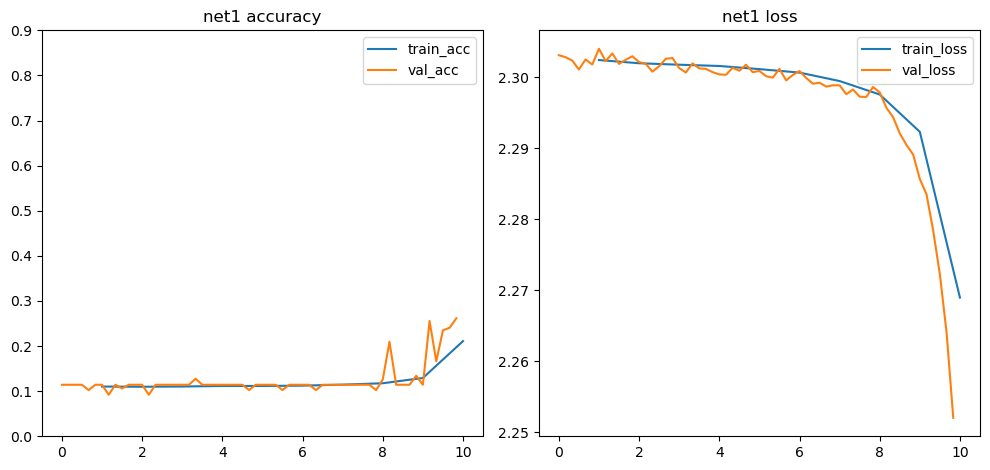

final loss: train 2.2689471451441445 v eval 2.252021074414253
final acc: train 0.210999995470047 v eval 0.26159998774528503


In [ ]:
fig, ax = plt.subplots(1, 2)
eval_per_epoch = 6

ax[0].plot(range(1, epochs+1), [train_acc[0] / train_acc[1] for train_acc in train_accs], label='train_acc')
ax[0].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], [val_acc[0] / val_acc[1] for val_acc in val_accs], label='val_acc')
ax[0].set_ylim(0.0, .9)
ax[0].set_title('net1 accuracy')
ax[0].legend()

ax[1].plot(range(1, epochs+1), train_loss, label='train_loss')
ax[1].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], val_loss, label='val_loss')
ax[1].set_title('net1 loss')
ax[1].legend()

fig.set_figwidth(10)

plt.tight_layout()
plt.show()

final_acc = (train_accs[-1], val_accs[-1])
final_loss = (train_loss[-1], val_loss[-1])

print(f"final loss: train {final_loss[0]} v eval {final_loss[1]}")
print(f"final acc: train {final_acc[0][0] / final_acc[0][1]} v eval {final_acc[1][0] / final_acc[1][1]}")

performed slightly better than the non-negative equivalent.

In [ ]:
with torch.no_grad():
    test_acc = (0, 0)
    for j, (test_X, test_y) in enumerate(test_loader):
        # evaluation loss and accuracy check
        output = net1(test_X)
        test_acc = tuple(a + b for a, b in zip(test_acc, accuracy(output, test_y)))

print(f" test accuracy: {100 * test_acc[0] / test_acc[1]}")

 test accuracy: 27.5


## Network 2
Network 1, but with ReLU activation instead of sigmoid.

In [5]:
eta = 0.1
epochs = 20

# Create a SummaryWriter instance
writer = SummaryWriter()

net2 = network.Network2()
print(net2)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net2.parameters(), lr=eta)
net2.zero_grad()

val_accs = []
val_loss = []
train_accs = []
train_loss = []
grad_norms_fc1 = []
grad_norms_fc2 = []
grad_norms_fc3 = []

total_loss = 0.
total_acc = (0, 0)

for epoch in range(epochs):
    print(f"epoch {epoch}")
    
    for i, (X, y) in enumerate(train_loader):
        net2.train() # training mode
        
        output = net2(X)
        loss = criterion(output, y)
        total_loss += loss.item()
        total_acc = tuple(a + b for a, b in zip(total_acc, accuracy(output, y)))
        
        loss.backward()
        if i == len(train_loader) - 1:
            grad_norms_fc1.append(torch.norm(net2.fc1.weight.grad))
            grad_norms_fc2.append(torch.norm(net2.fc2.weight.grad))
            grad_norms_fc3.append(torch.norm(net2.fc3.weight.grad))
        
        optimizer.step()
        optimizer.zero_grad()

        if i % 100 == 99: # for every 100th batch
            net2.eval() # evaluation mode
            
            with torch.no_grad():
                total_val_loss = 0.
                val_acc = (0, 0)
                for j, (val_X, val_y) in enumerate(validation_loader):
                    # evaluation loss and accuracy check
                    output = net2(val_X)
                    val_acc = tuple(a + b for a, b in zip(val_acc, accuracy(output, val_y)))
                    total_val_loss += criterion(output, val_y).item()
                print(f" evaluation accuracy: {100 * val_acc[0] / val_acc[1]}")
                val_accs.append(val_acc)
                val_loss.append(total_val_loss / len(validation_loader))
                
            print(f" training accuracy: {100 * total_acc[0] / total_acc[1]}")
            train_accs.append(total_acc)
            train_loss.append(total_loss / 100)
                        
            # Log scalar values
            writer.add_scalars('Net2 Loss', {'train': total_loss / 100, 'val': total_val_loss / len(validation_loader)}, epoch * len(train_loader) + i)
            writer.add_scalars('Net2 Acc', {'train': total_acc[0] / total_acc[1], 'val': val_acc[0] / val_acc[1]}, epoch * len(train_loader) + i)
            
            total_loss = 0.
            total_acc = (0, 0)
    

Network2(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)
epoch 0
 evaluation accuracy: 32.279998779296875
 training accuracy: 30.540000915527344
 evaluation accuracy: 40.099998474121094
 training accuracy: 39.66999816894531
 evaluation accuracy: 55.36000061035156
 training accuracy: 43.29999923706055
 evaluation accuracy: 59.08000183105469
 training accuracy: 57.63999938964844
 evaluation accuracy: 59.41999816894531
 training accuracy: 60.310001373291016
 evaluation accuracy: 59.91999816894531
 training accuracy: 61.20000076293945
epoch 1
 evaluation accuracy: 60.720001220703125
 training accuracy: 61.939998626708984
 evaluation accuracy: 66.95999908447266
 training accuracy: 65.7699966430664
 evaluation accuracy: 70.05999755859375
 training accuracy: 70.7300033569336
 evaluation accuracy: 70.37999725341797
 training accuracy: 70.58000183105469
 ev

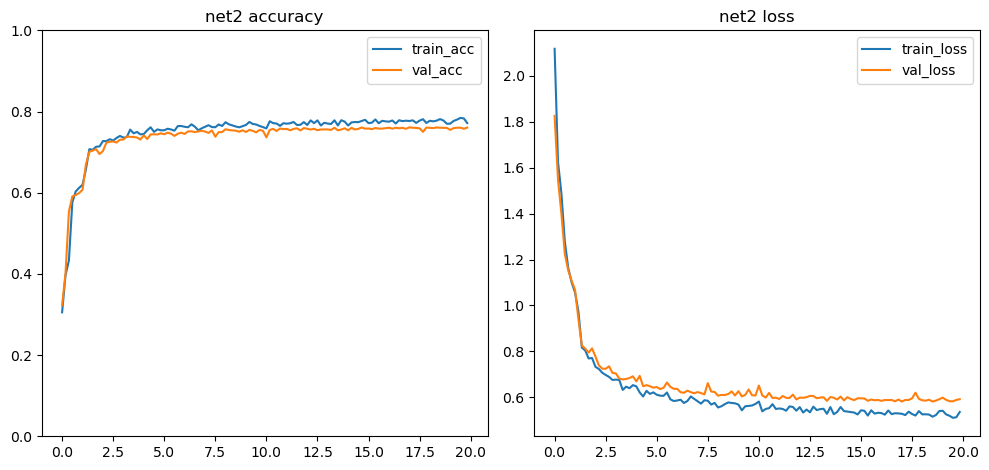

final loss: train 0.5361084005236626 v eval 0.5917012613346436
final acc: train 0.7714999914169312 v eval 0.7603999972343445


In [6]:
fig, ax = plt.subplots(1, 2)
eval_per_epoch = 6

ax[0].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], [train_acc[0] / train_acc[1] for train_acc in train_accs], label='train_acc')
ax[0].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], [val_acc[0] / val_acc[1] for val_acc in val_accs], label='val_acc')
ax[0].set_ylim(0., 1.)
ax[0].set_title('net2 accuracy')
ax[0].legend()

ax[1].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], train_loss, label='train_loss')
ax[1].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], val_loss, label='val_loss')
ax[1].set_title('net2 loss')
ax[1].legend()

fig.set_figwidth(10)

plt.tight_layout()
plt.show()

final_acc = (train_accs[-1], val_accs[-1])
final_loss = (train_loss[-1], val_loss[-1])

print(f"final loss: train {final_loss[0]} v eval {final_loss[1]}")
print(f"final acc: train {final_acc[0][0] / final_acc[0][1]} v eval {final_acc[1][0] / final_acc[1][1]}")

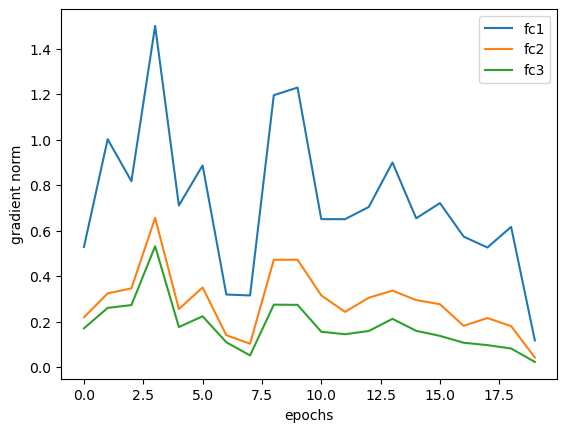

In [7]:
plt.plot(grad_norms_fc1, label='fc1')
plt.plot(grad_norms_fc2, label='fc2')
plt.plot(grad_norms_fc3, label='fc3')
plt.xlabel('epochs')
plt.ylabel('gradient norm')
plt.legend()
plt.show()

In [13]:
with torch.no_grad():
    test_acc = (0, 0)
    for j, (test_X, test_y) in enumerate(test_loader):
        # evaluation loss and accuracy check
        output = net2(test_X)
        test_acc = tuple(a + b for a, b in zip(test_acc, accuracy(output, test_y)))

print(f" test accuracy: {100 * test_acc[0] / test_acc[1]}")

 test accuracy: 77.5


In [14]:
with torch.no_grad():
    test_acc = (0, 0)
    for j, (test_X, test_y) in enumerate(test_loader_org):
        # evaluation loss and accuracy check
        output = net2(test_X)
        test_acc = tuple(a + b for a, b in zip(test_acc, accuracy(output, test_y)))

print(f" test accuracy: {100 * test_acc[0] / test_acc[1]}")

 test accuracy: 75.45999908447266


## Network 3
1 Convolutional layer, 2 fully connected layers.

In [8]:
eta = 0.1
epochs = 20
l2_lambda = 0.01
dropout = 0.2

# Create a SummaryWriter instance
writer = SummaryWriter()

net3 = network.Network3(dropout=dropout)
print(net3)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net3.parameters(), lr=eta)
net3.zero_grad()

val_accs = []
val_loss = []
train_accs = []
train_loss = []
grad_norms_fc1 = []
grad_norms_fc2 = []
grad_norms_conv = []
    
total_loss = 0.
total_acc = (0, 0)

layers_to_regularize = [net3.conv, net3.fc1]

for epoch in range(epochs):
    print(f"epoch {epoch}")
    
    total_loss = 0.
    total_acc = (0, 0)
    
    for i, (X, y) in enumerate(train_loader):
        net3.train() # training mode
        
        output = net3(X)
        loss = criterion(output, y)
        total_loss += loss.item()
        total_acc = tuple(a + b for a, b in zip(total_acc, accuracy(output, y))) # total_acc[0] + train_acc[0], total_acc[1] + train_acc[1]
        
        # l2 regularization
        l2_regularization = torch.tensor(0., requires_grad=True)
        for parameter in layers_to_regularize:
            l2_regularization = l2_regularization + torch.norm(parameter.weight, p=2) ** 2
        
        loss.backward()
        if i == len(train_loader) - 1:
            grad_norms_conv.append(torch.norm(net3.conv.weight.grad))
            grad_norms_fc1.append(torch.norm(net3.fc1.weight.grad))
            grad_norms_fc2.append(torch.norm(net3.fc2.weight.grad))
        optimizer.step()
        optimizer.zero_grad()

        if i % 100 == 99: # for every 100th batch
            net3.eval() # evaluation mode
            with torch.no_grad():
                total_val_loss = 0.
                val_acc = (0, 0)
                for j, (val_X, val_y) in enumerate(validation_loader):
                    # evaluation loss and accuracy check
                    output = net3(val_X)
                    val_acc = tuple(a + b for a, b in zip(val_acc, accuracy(output, val_y)))
                    total_val_loss += criterion(output, val_y).item()
                print(f" evaluation accuracy: {100 * val_acc[0] / val_acc[1]}")
                val_accs.append(val_acc)
                val_loss.append(total_val_loss / len(validation_loader))

            print(f" training accuracy: {100 * total_acc[0] / total_acc[1]}")
            train_accs.append(total_acc)
            train_loss.append(total_loss / 100)
                        
            # Log scalar values
            writer.add_scalars('Net2 Loss', {'train': total_loss / 100, 'val': total_val_loss / len(validation_loader)}, epoch * len(train_loader) + i)
            writer.add_scalars('Net2 Acc', {'train': total_acc[0] / total_acc[1], 'val': val_acc[0] / val_acc[1]}, epoch * len(train_loader) + i)
            
            total_loss = 0.
            total_acc = (0, 0)

Network3(
  (conv): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2880, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
epoch 0
 evaluation accuracy: 87.33999633789062
 training accuracy: 67.63999938964844
 evaluation accuracy: 91.19999694824219
 training accuracy: 89.01000213623047
 evaluation accuracy: 92.19999694824219
 training accuracy: 92.86000061035156
 evaluation accuracy: 94.81999969482422
 training accuracy: 94.12000274658203
 evaluation accuracy: 95.0999984741211
 training accuracy: 95.30000305175781
 evaluation accuracy: 95.54000091552734
 training accuracy: 95.79000091552734
epoch 1
 evaluation accuracy: 95.81999969482422
 training accuracy: 96.13999938964844
 evaluation accuracy: 96.0199966430664
 training accuracy: 96.69999694824219
 evaluation accuracy: 96.45999908447266
 training accuracy: 96.76000213623047
 evaluation accuracy: 96.68000030517578
 train

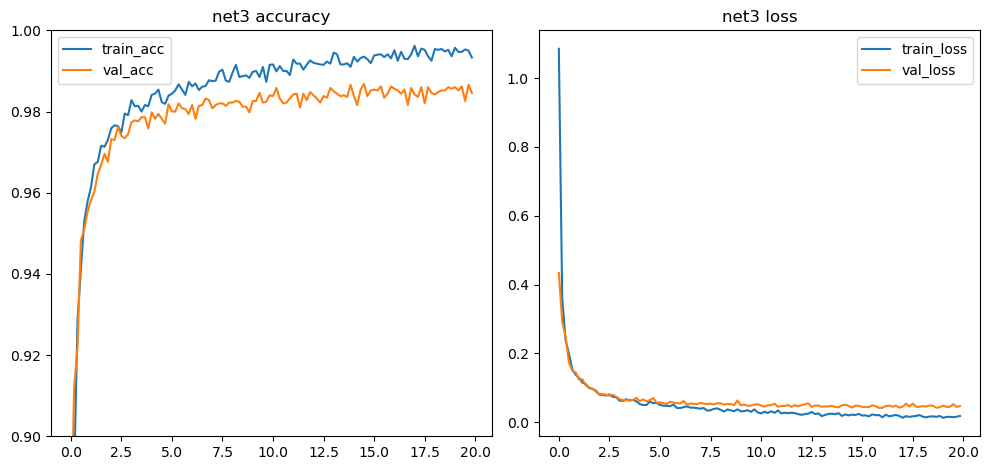

final loss: train 1.0849177700281143 v eval 0.3604866571724415
final acc: train 0.9933000206947327 v eval 0.9846000075340271


In [9]:
fig, ax = plt.subplots(1, 2)
eval_per_epoch = 6

ax[0].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], [train_acc[0] / train_acc[1] for train_acc in train_accs], label='train_acc')
ax[0].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], [val_acc[0] / val_acc[1] for val_acc in val_accs], label='val_acc')
ax[0].set_ylim(0.9, 1.)
ax[0].set_title('net3 accuracy')
ax[0].legend()

ax[1].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], train_loss, label='train_loss')
ax[1].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], val_loss, label='val_loss')
# ax[1].set_ylim(0.0, 1.)
ax[1].set_title('net3 loss')

fig.set_figwidth(10)

plt.tight_layout()
plt.legend()
plt.show()

final_acc = (train_accs[-1], val_accs[-1])
final_loss = (train_loss[-1], val_loss[-1])

print(f"final loss: train {train_loss[0]} v eval {train_loss[1]}")
print(f"final acc: train {final_acc[0][0] / final_acc[0][1]} v eval {final_acc[1][0] / final_acc[1][1]}")

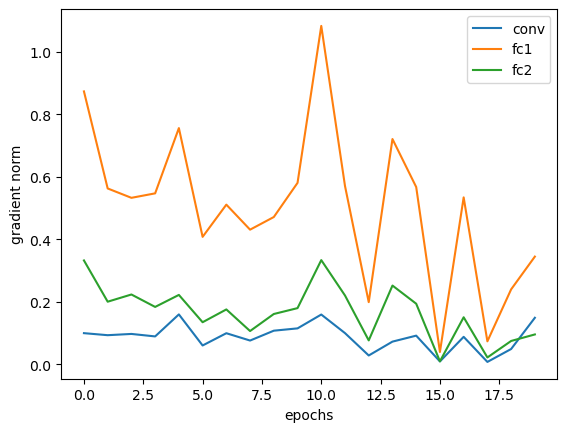

In [10]:
plt.plot(grad_norms_conv, label='conv')
plt.plot(grad_norms_fc1, label='fc1')
plt.plot(grad_norms_fc2, label='fc2')
plt.xlabel('epochs')
plt.ylabel('gradient norm')
plt.legend()
plt.show()

In [11]:
with torch.no_grad():
    test_acc = (0, 0)
    for j, (test_X, test_y) in enumerate(test_loader):
        # evaluation loss and accuracy check
        output = net3(test_X)
        test_acc = tuple(a + b for a, b in zip(test_acc, accuracy(output, test_y)))

print(f" test accuracy: {100 * test_acc[0] / test_acc[1]}")

 test accuracy: 99.5999984741211


In [12]:
with torch.no_grad():
    test_acc = (0, 0)
    for j, (test_X, test_y) in enumerate(test_loader_org):
        # evaluation loss and accuracy check
        output = net2(test_X)
        test_acc = tuple(a + b for a, b in zip(test_acc, accuracy(output, test_y)))

print(f" test accuracy: {100 * test_acc[0] / test_acc[1]}")

 test accuracy: 75.45999908447266
